In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from hmmlearn import hmm
import numpy as np
from morphelia.time_series import Saphire

In [2]:
import yfinance as yf

In [3]:
tickers = ["AXP",
             "AMGN",
             "AAPL",
             "BA",
             "CAT",
             "CSCO",
             "CVX",
             "GS",
             "HD",
             "HON",
             "IBM",
             "INTC",
             "JNJ",
             "JPM",
             "MCD",
             "MMM",
             "MRK",
             "WBA",
             "WMT",
             "DIS",
             "DOW"]

data = []

for ticker in tickers:
    print(f"Download ticker: {ticker}")
    df = yf.download(ticker,
                     start='2019-01-01',
                     end='2019-12-31',
                     progress=False)
    d = df[['Open', 'Close', 'Volume', 'Low', 'High']].to_numpy()
    data.append(d)


Download ticker: AXP
Download ticker: AMGN
Download ticker: AAPL
Download ticker: BA
Download ticker: CAT
Download ticker: CSCO
Download ticker: CVX
Download ticker: GS
Download ticker: HD
Download ticker: HON
Download ticker: IBM
Download ticker: INTC
Download ticker: JNJ
Download ticker: JPM
Download ticker: MCD
Download ticker: MMM
Download ticker: MRK
Download ticker: WBA
Download ticker: WMT
Download ticker: DIS
Download ticker: DOW


In [4]:
min_len = min([len(arr) for arr in data])
data = [arr[:min_len, :] for arr in data]


In [5]:
from morphelia.time_series import HMMSimilarity

hmm = HMMSimilarity(state_range=(5, 20), criterion='bic')
hmm.fit(data)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\hmmlearn\hmm.py:270: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


In [6]:
sim = hmm.similarity()

<AxesSubplot:>

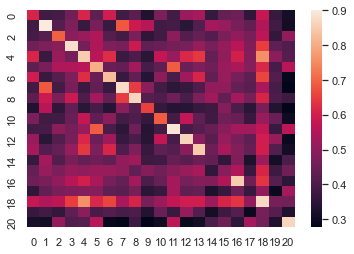

In [7]:
import seaborn as sns

sns.heatmap(sim)


In [2]:
ts = np.array([[ -8.965316  ,   0.24894676],
               [-14.359727  ,   2.2134545 ],
               [ -7.63601   ,   4.6547537 ],
               [-11.634, 3.456],
               [-6.436, 4.3456],
               [ -5.2306776 ,   3.2391331 ],
               [ -0.08836049,   3.1012967 ],
               [-5.34623, 5.43662],
               [  7.03162   ,  -1.2665539 ],
               [ 11.463842  ,  -2.8811202 ],
               [ 15.233757  ,  -4.1378765 ],
               [ 17.07934   ,  -3.4147086 ],
               [ 15.951399  ,   0.2038903 ]])


In [10]:
from hmmlearn.hmm import GaussianHMM

model = GaussianHMM(n_components=3, covariance_type='diag')
model.fit(ts)

GaussianHMM(n_components=3)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [81]:
states = model.predict(ts)
unique_states = list(range(model.n_components))
trans = model.transmat_.copy()
diag_ix = np.diag_indices_from(trans)
trans[diag_ix] = 0
trans = ((trans - trans.min()) / (trans.max() - trans.min())) * 5
means = model.means_.copy()
station_dist = model.get_stationary_distribution()

G = nx.DiGraph()
for st in unique_states:
    pos = means[st, :]
    sd = station_dist[st] * 1000
    G.add_node(f"{st}", pos=pos, sd=sd)

for st in unique_states:
    for _st in unique_states:
        G.add_edge(f"{st}", f"{_st}", weight=trans[st, _st])

widths = nx.get_edge_attributes(G, 'weight')
print(widths)
mean_pos = nx.get_node_attributes(G, 'pos')
sds = nx.get_node_attributes(G, 'sd')

{('0', '0'): 0.0, ('0', '1'): 3.177111046894782e-52, ('0', '2'): 2.2098181583546576e-89, ('1', '0'): 1.6407822902486815, ('1', '1'): 0.0, ('1', '2'): 2.4873249264158075e-06, ('2', '0'): 2.2089370441451447e-33, ('2', '1'): 5.0, ('2', '2'): 0.0}


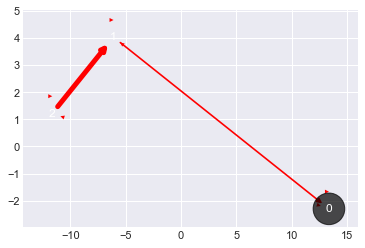

In [82]:
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos=mean_pos,
                       nodelist=G.nodes(),
                       node_size=list(sds.values()),
                       node_color='black',
                       alpha=0.7,
                       ax=ax)
nx.draw_networkx_edges(G, pos=mean_pos,
                       edgelist=widths.keys(),
                       width=list(widths.values()),
                       edge_color='red',
                       ax=ax)
nx.draw_networkx_labels(G, pos=mean_pos,
                        labels=dict(zip(G.nodes(), G.nodes())),
                        font_color='white',
                        ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [77]:
widths

{('0', '0'): 0.0,
 ('0', '1'): 0.0,
 ('0', '2'): 0.0,
 ('1', '0'): 0.0,
 ('1', '1'): 0.0,
 ('1', '2'): 0.0,
 ('2', '0'): 0.0,
 ('2', '1'): 0.0,
 ('2', '2'): 0.0}

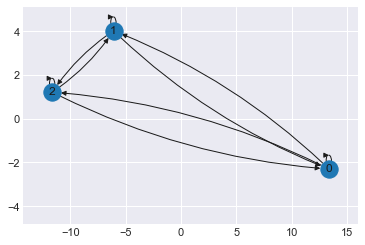

In [41]:
fig, ax = plt.subplots()
nx.draw(G, pos=mean_pos, with_labels=True, connectionstyle='arc3, rad = 0.1', ax=ax)
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


In [39]:
mean_pos

{'st': array([-11.6273113 ,   1.22080004])}

In [35]:
nx.spring_layout(G)

{'0': array([0.25293167, 0.91607035]),
 '1': array([-1.        ,  0.01797884]),
 '2': array([ 0.74706833, -0.9340492 ])}

In [19]:
G.edges

OutEdgeView([('0', '0'), ('0', '1'), ('0', '2'), ('1', '0'), ('1', '1'), ('1', '2'), ('2', '0'), ('2', '1'), ('2', '2')])

In [23]:
G.pos

AttributeError: 'DiGraph' object has no attribute 'pos'

In [4]:
ct = Saphire(model, ts)

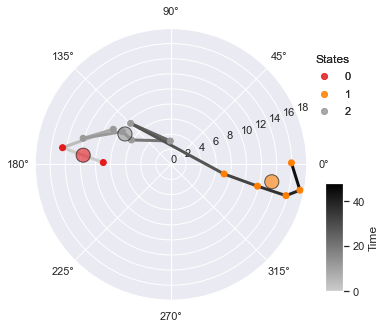

(<Figure size 360x360 with 2 Axes>, <PolarAxesSubplot:>)

In [5]:
ct.plot_traj(projection='polar', ymax=18)

(<Figure size 360x360 with 2 Axes>, <PolarAxesSubplot:>)

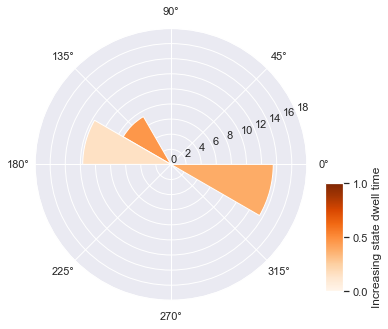

In [6]:
ct.plot_states(ymax=18)

(<Figure size 360x360 with 2 Axes>, <PolarAxesSubplot:>)

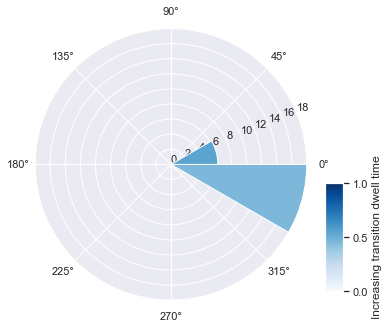

In [7]:
ct.plot_transition(ymax=18)

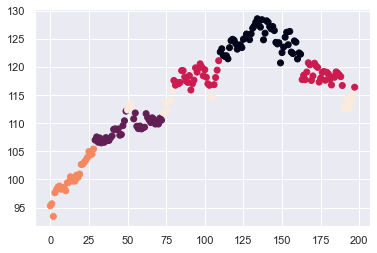

In [32]:
import matplotlib.pyplot as plt
x = list(range(ts.shape[0]))

fig, ax = plt.subplots()
ax.scatter(x, ts[:, 1], c=Z)

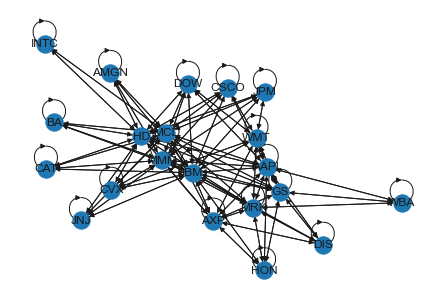

In [99]:
import networkx as nx

A = sim.copy()
A[A < 0.4] = 0
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), tickers)))
pos = nx.spring_layout(G, weight='weight')

nx.draw(G, pos=pos, with_labels=True)

In [97]:
pos

{'AXP': array([ 0.31177339, -0.25663823]),
 'AMGN': array([-1.        ,  0.27334268]),
 'AAPL': array([ 0.05130992, -0.07657415]),
 'BA': array([-0.93993683, -0.33433396]),
 'CAT': array([-0.58424701, -0.80116928]),
 'CSCO': array([ 0.83914672, -0.48502615]),
 'CVX': array([-0.00212166,  0.83926021]),
 'GS': array([ 0.84723465, -0.01088572]),
 'HD': array([-0.01440722,  0.36979458]),
 'HON': array([ 0.02991323, -0.45268854]),
 'IBM': array([-0.20516219, -0.28626342]),
 'INTC': array([-0.65878802,  0.66564129]),
 'JNJ': array([0.38747771, 0.93734457]),
 'JPM': array([0.78697041, 0.55798598]),
 'MCD': array([-0.15618152,  0.15877268]),
 'MMM': array([0.25039872, 0.27659334]),
 'MRK': array([ 0.49005797, -0.68055088]),
 'WBA': array([-0.41220286,  0.22473176]),
 'WMT': array([0.40448682, 0.04138339]),
 'DIS': array([-0.4405479 , -0.13444763]),
 'DOW': array([ 0.01482567, -0.82627253])}

In [52]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=4)
model.fit(data[1])

GaussianHMM(n_components=4)

In [55]:
model._compute_log_likelihood(data[1])

array([[ -85.72088798,  -40.73650145,  -30.7226487 ,  -22.95858707],
       [ -74.03868227,  -34.07331778,  -34.20414629,  -21.22744309],
       [ -71.52921039,  -32.52209088,  -36.00692652,  -24.28568331],
       [ -87.48954588,  -41.00619781,  -31.15321049,  -27.04017581],
       [-107.00821023,  -55.52735881,  -26.7534921 ,  -33.94067787],
       [-129.50010806,  -74.15793567,  -24.77916263,  -52.33038688],
       [-146.26506582,  -90.03013609,  -24.61662804,  -70.36238997],
       [-148.13100714,  -90.15387575,  -24.65566263,  -71.5537419 ],
       [-135.11010121,  -79.57550588,  -24.6167011 ,  -58.2154538 ],
       [-120.19540029,  -67.40330783,  -25.32392788,  -45.10110205],
       [-117.59995031,  -64.06305698,  -25.54194472,  -41.46361192],
       [-126.7809393 ,  -72.3950808 ,  -24.83139558,  -50.18262821],
       [-136.62071559,  -79.82538459,  -24.78863276,  -58.83517041],
       [-163.33464662, -104.94257902,  -25.25411597,  -89.671062  ],
       [-154.65538168,  -97.206288

In [17]:
log_p = model._compute_log_likelihood(X_1)

In [19]:
from scipy.spatial.distance import jensenshannon as js

js(log_p[:, 0], log_p[:, 1])

0.35226089940436894

In [80]:
from morphelia.time_series.hmm import HMM_similarity

HMM_similarity(model, model, data[1], data[1])


0.9997328249812861

In [85]:
np.triu_indices(10)



(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4,
        5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8,
        9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9], dtype=int64))